In [1]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

n_splits = 5
SEED = 42

In [2]:

import logging

# 创建日志记录器
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# 创建日志文件的处理器
file_handler = logging.FileHandler('./test.log', mode='w')

# 创建日志格式
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# 将格式应用到处理器
file_handler.setFormatter(formatter)

# 将处理器添加到日志记录器
logger.addHandler(file_handler)

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [4]:
#加载(timeseries)数据

#process_file处理一个文件（一个id），从文件中提取一般信息，如每个特征的计数、均值、标准差、最小值、25%分位数、50%分位数、75%分位数和最大值。
#然后，将特征矩阵展平为一个向量，以表示文件中的数据。
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))#df是一个dataframe
    #print(df)
    df.drop('step', axis=1, inplace=True)#删除了 DataFrame 中名为 'step' 的列。step就是0,1,2,3....
    #去掉step列后df有12列，都是特征列
    #print()
    #print(df)
    #print(df.describe())
    return df.describe().values.reshape(-1), filename.split('=')[1]
#返回值1：df.describe().values是df中的各列的count、mean等待的数值部分（一个numpy数组），.reshape(-1)多维数组(12列*8）展平为一维数组（一列的各个值在一起）（-1 表示根据数组的总元素数自动推算维度）。
#返回值2：这个文件的用户id

#load_time_series：格式化并加载文件夹中所有已处理的文件。（处理一个大文件夹时的文件，很多id)
#返回结果是一个dataframe,每行表示一个用户id,每列是一个describe(共96个这样的列)，但最后一列是用户id
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:#用于并行处理
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
        #tqdm是进度条 list()转化为列表   executor.map对每个文件并行处理   
    
    stats, indexes = zip(*results)# *zip是解压缩
    #将 results 中的所有元组解包，分别得到两个列表。
    #stats 包含所有文件的描述性统计信息(文件中12个列的count、mean等）（即 process_file 函数的第一个返回值），
    #而 indexes 包含所有文件名的id（即 process_file 函数的第二个返回值）。
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    #把stats转化为dataframe df,列名为Stat_0,Stat_1....   每行表示一个文件（一个id)，共96列
    
    df['id'] = indexes
    #加一id这一列
    
    #print()
    #print("stats",stats)
    #print()
    # print("df",df)
    
    return df

In [5]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()#所有列名的list
time_series_cols.remove("id")#去掉id这一列
print(time_series_cols)

100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

['Stat_0', 'Stat_1', 'Stat_2', 'Stat_3', 'Stat_4', 'Stat_5', 'Stat_6', 'Stat_7', 'Stat_8', 'Stat_9', 'Stat_10', 'Stat_11', 'Stat_12', 'Stat_13', 'Stat_14', 'Stat_15', 'Stat_16', 'Stat_17', 'Stat_18', 'Stat_19', 'Stat_20', 'Stat_21', 'Stat_22', 'Stat_23', 'Stat_24', 'Stat_25', 'Stat_26', 'Stat_27', 'Stat_28', 'Stat_29', 'Stat_30', 'Stat_31', 'Stat_32', 'Stat_33', 'Stat_34', 'Stat_35', 'Stat_36', 'Stat_37', 'Stat_38', 'Stat_39', 'Stat_40', 'Stat_41', 'Stat_42', 'Stat_43', 'Stat_44', 'Stat_45', 'Stat_46', 'Stat_47', 'Stat_48', 'Stat_49', 'Stat_50', 'Stat_51', 'Stat_52', 'Stat_53', 'Stat_54', 'Stat_55', 'Stat_56', 'Stat_57', 'Stat_58', 'Stat_59', 'Stat_60', 'Stat_61', 'Stat_62', 'Stat_63', 'Stat_64', 'Stat_65', 'Stat_66', 'Stat_67', 'Stat_68', 'Stat_69', 'Stat_70', 'Stat_71', 'Stat_72', 'Stat_73', 'Stat_74', 'Stat_75', 'Stat_76', 'Stat_77', 'Stat_78', 'Stat_79', 'Stat_80', 'Stat_81', 'Stat_82', 'Stat_83', 'Stat_84', 'Stat_85', 'Stat_86', 'Stat_87', 'Stat_88', 'Stat_89', 'Stat_90', 'Stat_91

In [6]:
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')


train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [7]:
train = train.dropna(subset='sii')#本来3960行

In [8]:
train_sii=train['sii']

In [9]:
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
#这些列都是与season有关的，列的值本来是spring...,用astype('category')变为category型，处理更快，虽然还是写为spring
season_mapping={'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4,'Missing':5}

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')#把这些列中缺失的值补为Missing
        #df[c] = df[c].astype('category')
    for c in cat_c:
        df[c]=df[c].map(season_mapping)
    return df
        
train = update(train)
test = update(test)


In [10]:
columns=test.columns
train_sii=train['sii']
train=train[columns]
train['sii']=train_sii

In [11]:
def feature_engineering(df):#用于在一个 DataFrame 中创建新的特征
    #先删除season有关的列
    #season_cols = [col for col in df.columns if 'Season' in col]
    #df = df.drop(season_cols, axis=1) 
    
    #加很多新列
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']#BMI*年龄
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['hoursday_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] / df['BMI_Age']

    df['Age_Weight'] = df['Basic_Demos-Age'] * df['Physical-Weight']
    df['Sex_BMI'] = df['Basic_Demos-Sex'] * df['Physical-BMI']
    df['Sex_HeartRate'] = df['Basic_Demos-Sex'] * df['Physical-HeartRate']
    df['Age_WaistCirc'] = df['Basic_Demos-Age'] * df['Physical-Waist_Circumference']
    df['BMI_FitnessMaxStage'] = df['Physical-BMI'] * df['Fitness_Endurance-Max_Stage']
    df['Weight_GripStrengthDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSD']
    df['Weight_GripStrengthNonDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSND']
    df['HeartRate_FitnessTime'] = df['Physical-HeartRate'] * (df['Fitness_Endurance-Time_Mins'] + df['Fitness_Endurance-Time_Sec'])
    df['Age_PushUp'] = df['Basic_Demos-Age'] * df['FGC-FGC_PU']
    df['FFMI_Age'] = df['BIA-BIA_FFMI'] * df['Basic_Demos-Age']
    df['InternetUse_SleepDisturbance'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['SDS-SDS_Total_Raw']
    df['CGAS_BMI'] = df['CGAS-CGAS_Score'] * df['Physical-BMI']
    df['CGAS_FitnessMaxStage'] = df['CGAS-CGAS_Score'] * df['Fitness_Endurance-Max_Stage']
    
    return df

In [12]:
train=feature_engineering(train)
test=feature_engineering(test)

In [13]:
#现在train里sii没有缺失值
#KNN法补全缺失值      ?????如果用mean????

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64', 'int64','float32']).columns#数据框 train 中所有数值型的列（即 float64 和 int64 类型的列）。
train[numeric_cols] = train[numeric_cols].replace([np.inf, -np.inf], np.nan)#无穷大变成nan
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)

numeric_cols = test.select_dtypes(include=['float64', 'int64','float32']).columns#数据框 train 中所有数值型的列（即 float64 和 int64 类型的列）。
test[numeric_cols] = test[numeric_cols].replace([np.inf, -np.inf], np.nan)

imputed_data = imputer.fit_transform(test[numeric_cols])
test_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)

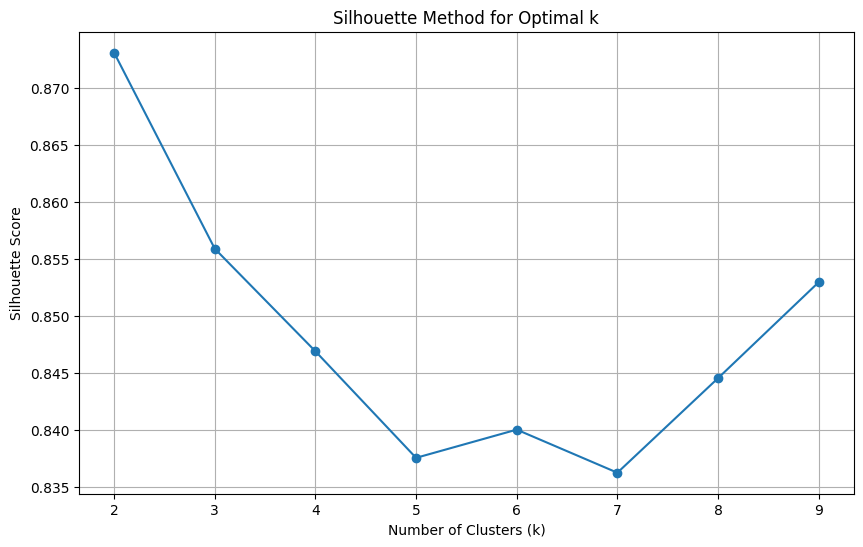

In [14]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

silhouette_scores = []#-1到1，越接近1越好
k_range = range(2, 10)  # Adjust range as needed

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(train_imputed)
    silhouette_avg = silhouette_score(train_imputed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid()
plt.show()

In [15]:
train=train_imputed
test=test_imputed

In [16]:
#K-Means
optimal_k = 9  #cluster数取2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)#把数据分为2个聚类的模型
clusters = kmeans.fit_predict(train)#cluster是一个n个元素的数组，n是mean_values_df的行数（数据点数），每个元素是这个数据点属于哪个聚类
#fit训练，从mean_values_df里确定2个聚类（每个列是一个特征），predict,预测每个数据点属于哪个聚类 

# 將群集标签加入到 DataFrame，作为一个新的特征列
train['Cluster'] = clusters

clusters = kmeans.fit_predict(test)
test['Cluster'] = clusters

In [17]:
from sklearn.cluster import DBSCAN
# Perform DBSCAN clustering基于密度的带噪声应用空间聚类
dbscan = DBSCAN(eps=3.5, min_samples=30)  #eps表示两个点之间的最大距离,min_samples=30：表示一个聚类最小需要的点数
train_clusters = dbscan.fit_predict(train)
#返回一个包含每个点所属聚类标签的数组。噪声点会被标记为 -1，其他点则会被分配一个正整数标签，表示它们属于某个特定的聚类。

print(f"Unique clusters: {len(np.unique(train_clusters[train_clusters != -1]))}")#聚类个数
print(f"Noise points: {np.sum(train_clusters == -1)}")#噪声点的数量

test_clusters = dbscan.fit_predict(test)

train['cluster2']=train_clusters
test['cluster2']=test_clusters

Unique clusters: 2
Noise points: 1000


In [18]:
#接下来是有关评估的函数

#计算QWK值 -1 到 1 之间，值越高，表示预测结果越准确
def quadratic_weighted_kappa(y_true, y_pred):#y_true是真实的sii,y_pred是预测的sii
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
#最初的train数据里有PCIAT_Total这一列，sii的值就是按这个值分为0，1，2，3的
#看off_non_rounded(实际输入的是PCIAT_Total的值）在哪一个范围内，返回对应的sii
#不是从PCIAT_Total，而是预测得到的sii不是整数值，要以几个threshold把它们划分为0,1,2,3这几个整数
def threshold_Rounder(oof_non_rounded, thresholds):#thresholds是一个个的区间端点
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))
#先将整数型预测值转换为分类值，然后计算预测值与真实标签之间的 QWK 值来评估模型的预测效果。
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)#  返回的是-，因为后面用的minimize，而QWK越大越好

In [19]:
train.shape

(2736, 186)

In [20]:
#下面是训练模型：使用 K-Fold 训练模型，该模型是回归模型，用于预测sii。由于这些值可能没有明确的差异，因此我们重新定义阈值以使分类更加准确
def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)#X是去掉sii这一列的train
    y = train['sii']#真实sii

    # Apply K-Fold（K折交叉验证）一种模型评估方法
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True)#一个K-fold模型
    #把原train数据分为k个子集，进行k次训练，每次用一个子集作验证集，剩下k-1个是训练集。评估指标（如准确率、精确度、召回率等），最后取平均
    
    train_S = []
    val_S = []#每一折的训练集与验证集的分别的kappa值
    
    oof_non_rounded = np.zeros(len(y), dtype=float) #和y一样大小，用来装train得到的预测的sii
    oof_rounded = np.zeros(len(y), dtype=int)   #train得到的预测sii,四舍五入过了   
    #每一折的时候oof_non_rounded，oof_rounded存的都是这一折的验证集val的预测sii，最后所有折结束后也得到了所有train的预测sii
    test_preds = np.zeros((len(test_data), n_splits))#test的预测的sii 每折都有一列

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        #fold是每一折的索引0,1,2.... train_idx 和 val_idx 是训练集和验证集的索引。
        # Train model
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]  #train 是训练集，val是验证集
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = clone(model_class)#克隆一个新的模型实例，确保每一折的训练都是独立的。model_class是传入的模型
        model.fit(X_train, y_train)#训练

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Round to integer values  round表示四舍五入
        oof_non_rounded[val_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[val_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        val_S.append(val_kappa)
        
        #使用外面的测试数据test_data（不是K-fold分的验证集）进行预测，
        #并将预测结果存储在 test_preds 中的当前折（fold）列。
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        # 在这里使用logger.info来输出每一折的训练和验证QWK
        logging.info(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)
        

        #clear_output(wait=True)

    # 计算平均QWK并记录
    logging.info(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    logging.info(f"Mean Validation QWK ---> {np.mean(val_S):.4f}")
    
    #对每一折的train_kappa,val_kappa分别求平均
    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(val_S):.4f}")

    # Using optimizer to find the best threshold
    #使用优化器找到分sii的最佳阈值
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    #minimize 是来自 scipy.optimize 的函数，目的是 最小化目标函数。这里的目标函数是 evaluate_predictions（最后的QWK），
    #即通过优化调整阈值来最大化QWK得分。
    #x0=[0.5, 1.5, 2.5] 是初始猜测的阈值，args是evaluate_predictions的后两个参数（第一个参数是要优化的thresholds）
    assert KappaOPtimizer.success, "Optimization did not converge."#检查优化过程是否收敛

    # Use the threshold retrive from the optimizer to predict again to evaluate
    #KappaOPtimizer.x就是优化得到的最佳阈值，用它再对不整的sii进行划分sii，与求kappa
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    # Use the threshold retrive from the optimizer to predict test
    tpm = test_preds.mean(axis=1)#求平均
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    # Create submition   test_data的id与最终预测sii
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

   

    return submission

In [21]:
LGBM_Params = {
    'learning_rate': 0.04,
    'max_depth': 12,
    'num_leaves': 413,
    'min_data_in_leaf': 14,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.76,
    'bagging_freq': 2,
    'lambda_l1': 4.735,
    'lambda_l2': 4.735e-06,
    'random_state': SEED}
LGBM_Model = lgb.LGBMRegressor(**LGBM_Params, verbose=-1, n_estimators=200)
# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.04,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED}
XGB_Model = XGBRegressor(**XGB_Params)

#CatBoost parameters
'''
CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
'''
Voting_Model = VotingRegressor(estimators=[
    ('lightgbm', LGBM_Model),
    ('xgboost', XGB_Model)
    #('catboost', CatBoost_Model)
])


Submission3= TrainML(Voting_Model,test)


#Submission3 = TrainML(LGBM_Model, test)

Training Folds: 100%|██████████| 5/5 [00:39<00:00,  7.94s/it]

Mean Train QWK --> 0.8947
Mean Validation QWK ---> 0.3961


----> || Optimized QWK SCORE ::  0.452


In [24]:
Submission3.to_csv('submission.csv', index=False)
print(Submission3['sii'].value_counts())

sii
1    15
0     5
Name: count, dtype: int64
